In [47]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Exploration

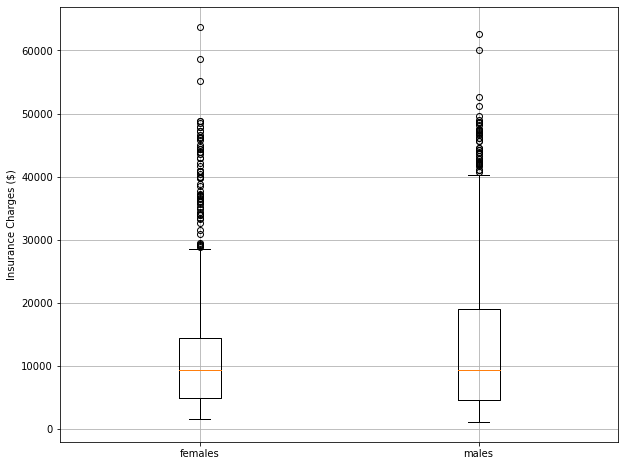

In [2]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
females = insurance[insurance['sex'] == 'female']
males = insurance[insurance['sex'] == 'male']

## Creating side-by-side box plots
plt.boxplot([females['charges'], males['charges']], labels = ['females', 'males'])
plt.ylabel('Insurance Charges ($)')
plt.grid()

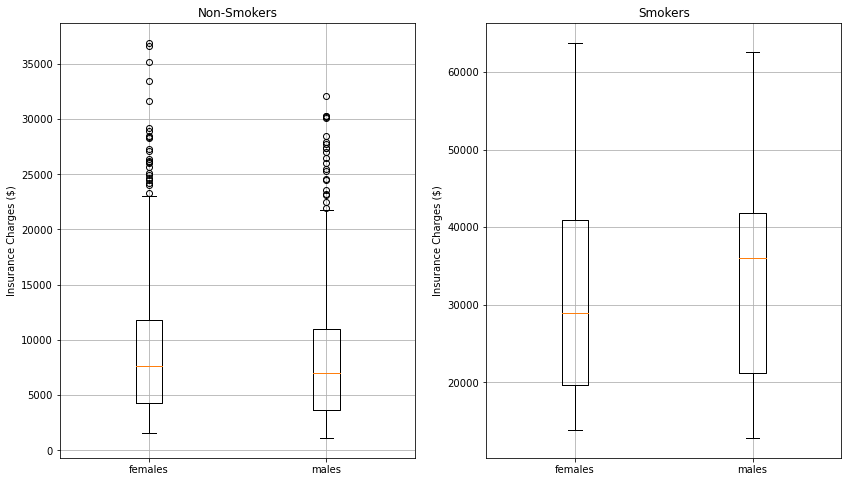

In [3]:
## Creating a new figure
fig, axes = plt.subplots(1, 2, figsize = (14, 8))

## Subsetting the data
nonsmokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'no')]
nonsmokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'no')]

smokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'yes')]
smokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'yes')]

axes[0].boxplot([nonsmokers_females['charges'], nonsmokers_males['charges']], labels = ['females', 'males'])
axes[0].set_ylabel('Insurance Charges ($)')
axes[0].set_title('Non-Smokers')
axes[0].grid()

## Plotting the second histogram
axes[1].boxplot([smokers_females['charges'], smokers_males['charges']], labels = ['females', 'males'])
axes[1].set_ylabel('Insurance Charges ($)')
axes[1].set_title('Smokers')
axes[1].grid()

In [48]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 151393593.061\nsamples = 1070\nvalue = 13364.915'),
 Text(348.75, 509.625, 'age <= 43.5\nmse = 35743115.755\nsamples = 841\nvalue = 8290.363'),
 Text(174.375, 305.775, 'age <= 22.5\nmse = 20707453.192\nsamples = 490\nvalue = 5341.219'),
 Text(87.1875, 101.92499999999995, 'mse = 10250852.315\nsamples = 138\nvalue = 2672.071'),
 Text(261.5625, 101.92499999999995, 'mse = 20918837.199\nsamples = 352\nvalue = 6387.646'),
 Text(523.125, 305.775, 'age <= 51.5\nmse = 27641315.43\nsamples = 351\nvalue = 12407.403'),
 Text(435.9375, 101.92499999999995, 'mse = 19501750.564\nsamples = 140\nvalue = 10140.023'),
 Text(610.3125, 101.92499999999995, 'mse = 27367587.667\nsamples = 211\nvalue = 13911.826'),
 Text(1046.25, 509.625, 'bmi <= 30.01\nmse = 134238827.34\nsamples = 229\nvalue = 32001.152'),
 Text(871.875, 305.775, 'age <= 41.0\nmse = 24873043.993\nsamples = 110\nvalue = 21404.256'),
 Text(784.6875, 101.92499999999995, 'mse = 13466647.132\nsamples = 6

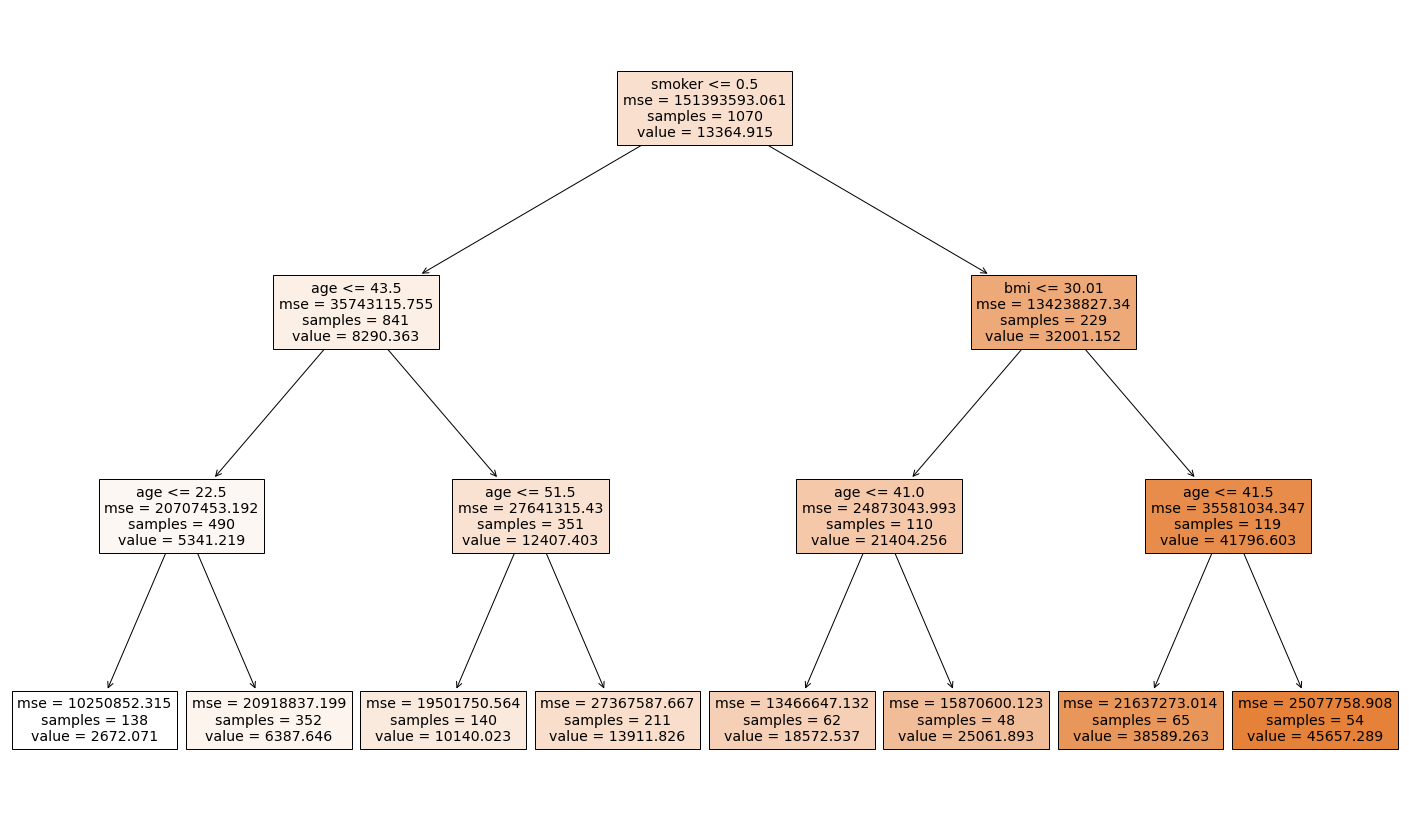

In [49]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

## saving the plot
# plt.savefig('chapter4_plot3.pdf')

In [50]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

## Recursive Feature Elimination (RFE)

In [18]:
## Running RFE with Random forest model
RF_rfe = RFE(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), n_features_to_select = 5).fit(X_train, Y_train)

## Extracting rankings
print(RF_rfe.ranking_)

## Extracting actual feature names
a = X_train.columns[RF_rfe.support_]
print(X_train.columns[RF_rfe.support_])

[1 8 1 1 1 7 6 5 3 4 1 2]
Index(['age', 'bmi', 'children', 'smoker', 'interaction_3'], dtype='object')


## RFE Hyper-Parameters

In [4]:
def flat_list(my_list):
    
    out_list = list()
    for i in my_list:
        out_list += i
    return out_list


def RF_RFE_rep_cross_val(X, Y, numb_folds, max_features, numb_reps):
    
    ## Defining list to store results 
    RFE_rep_results = list()
    
    for i in range(2, max_features):
        print(i)
        RFE_rep_results.append(RF_rep_cross_val(X, Y, numb_folds, i, numb_reps))
        
    return RFE_rep_results
    

def RF_rep_cross_val(X, Y, numb_folds, numb_features, numb_reps):
    
    ## Defining the list to store results 
    rep_results = list()
    
    for i in range(0, numb_reps):
        
        rep_results.append(RF_cross_val(X, Y, numb_folds, numb_features))
        
    return flat_list(rep_results)


def RF_cross_val(X, Y, numb_folds, numb_features):
    
    ## Defining list to store results 
    results = list()
    
    ## Defining the number of folds
    kf = KFold(n_splits = numb_folds, shuffle = True)
    
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
        ## Running RFE with i features
        RF_rfe = RFE(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), n_features_to_select = numb_features).fit(X_train, Y_train)

        ## Variable to be considered
        to_select = X_train.columns[RF_rfe.support_]
        
        ## Building the Random Forest model 
        X_train_md = X_train[to_select]
        X_test_md = X_test[to_select]
        RF_md = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(X_train_md, Y_train)
        
        ## Predicting on the test data-frame and storing RMSE
        results.append(mean_squared_error(Y_test, RF_md.predict(X_test_md), squared = False))
        
    return results

2
3
4
5
6
7
8


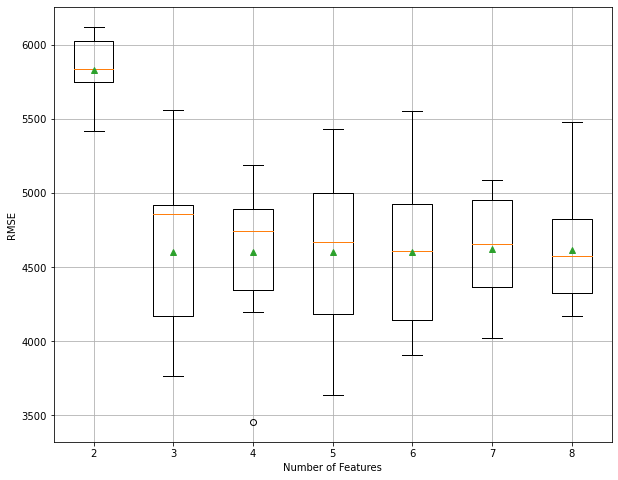

In [5]:
## Running RFE with CV to estimate number of features to be selected (manually)
RFE_numb_features = RF_RFE_rep_cross_val(X_train, Y_train, numb_folds = 5, max_features = 9, numb_reps = 3)

## Visualizing the results
fig = plt.figure(figsize = (10, 8))

plt.boxplot(RFE_numb_features, labels = [2, 3, 4, 5, 6, 7, 8], showmeans = True)
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.grid()

## saving the plot
# plt.savefig('chapter4_plot4.pdf')

plt.show()

## RFE Automated Selectiing Number of Features

In [23]:
## Running RFECV one time 
auto_feature_selection = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)

## Identifying feautures to be selected
print(auto_feature_selection.support_)

## Printin the rankings
print(auto_feature_selection.ranking_)

[ True False  True  True  True False  True  True  True  True  True  True]
[1 3 1 1 1 2 1 1 1 1 1 1]


In [29]:
## Running RFECV multiple times
RFE_results = list()

for i in range(0, 10):
    
    ## Running RFECV
    auto_feature_selection = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)

    ## Extracting and storing features to be selected
    RFE_results.append(auto_feature_selection.support_)

## Changing to data-frame 
RFE_results = pd.DataFrame(RFE_results)
RFE_results.columns = X_train.columns

## Identifying features to be selected
100*RFE_results.apply(np.sum, axis = 0) / RFE_results.shape[0]

age              100.0
sex               40.0
bmi              100.0
children         100.0
smoker           100.0
northeast         60.0
northwest         70.0
southeast         70.0
interaction_1    100.0
interaction_2     80.0
interaction_3    100.0
interaction_4     90.0
dtype: float64

## Exploring the Base Algorithm with RFECV

In [45]:
## Standardizing the inputs
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)


# auto_feature_selection = RFECV(estimator = SVR(kernel = 'poly'), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)

auto_feature_selection = RFECV(estimator = Lasso(alpha = 0.01, max_iter = 100000), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)

# auto_feature_selection = RFECV(estimator = LinearRegression(), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)


## Identifying feautures to be selected
print(auto_feature_selection.support_)

[ True False  True  True  True False False False  True False False False]


In [46]:
X_train

array([[0.80434783, 1.        , 0.51883239, ..., 0.        , 0.        ,
        1.        ],
       [0.7826087 , 0.        , 0.31436642, ..., 0.        , 0.        ,
        1.        ],
       [0.93478261, 0.        , 0.40893193, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.41304348, 0.        , 0.28087167, ..., 0.        , 0.        ,
        0.        ],
       [0.02173913, 1.        , 0.38848534, ..., 0.        , 0.        ,
        0.        ],
       [0.7826087 , 0.        , 0.43960183, ..., 0.        , 0.        ,
        1.        ]])

In [52]:
## Standardizing the inputs
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

## Running RFECV multiple times
RFE_linear_results = list()
RFE_lasso_results = list()
RFE_RF_results = list()
RFE_Ada_results = list()
RFE_GB_results = list()

for i in range(0, 2):
    print(i)
    ## Running RFECV with different base models
    Linear_feature_selection = RFECV(estimator = LinearRegression(), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)
    Lasso_feature_selection = RFECV(estimator = Lasso(alpha = 0.01, max_iter = 100000), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)
    RF_feature_selection = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)
    Ada_feature_selection = RFECV(estimator = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 3), n_estimators = 500, learning_rate = 0.01), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)
    GB_feature_selection = RFECV(estimator = GradientBoostingRegressor(max_depth = 3, n_estimators = 500, learning_rate = 0.01), step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)
    
    ## Extracting and storing features to be selected
    RFE_linear_results.append(Linear_feature_selection.support_)
    RFE_lasso_results.append(Lasso_feature_selection.support_)
    RFE_RF_results.append(RF_feature_selection.support_)
    RFE_Ada_results.append(Ada_feature_selection.support_)
    RFE_GB_results.append(GB_feature_selection.support_)

## Changing to data-frame 
RFE_linear_results = pd.DataFrame(RFE_linear_results)
RFE_linear_results.columns = X_train.columns

RFE_svm_results = pd.DataFrame(RFE_svm_results)
RFE_svm_results.columns = X_train.columns

RFE_RF_results = pd.DataFrame(RFE_RF_results)
RFE_RF_results.columns = X_train.columns

RFE_Ada_results = pd.DataFrame(RFE_Ada_results)
RFE_Ada_results.columns = X_train.columns

RFE_GB_results = pd.DataFrame(RFE_GB_results)
RFE_GB_results.columns = X_train.columns


## Identifying features to be selected
# 100*RFE_results.apply(np.sum, axis = 0) / RFE_results.shape[0]

0
1


In [54]:
RFE_linear_results

,age,sex,bmi,children,smoker,northeast,northwest,southeast,interaction_1,interaction_2,interaction_3,interaction_4
0,True,False,True,True,True,True,True,False,True,True,True,True
1,True,False,True,True,True,True,True,False,True,True,True,True


In [ ]:
RFE_svm_results

In [55]:
RFE_svm_results

,age,sex,bmi,children,smoker,northeast,northwest,southeast,interaction_1,interaction_2,interaction_3,interaction_4
0,True,False,True,True,True,True,True,False,False,True,True,False
1,True,False,True,True,True,True,True,False,False,True,True,False


In [53]:
RFE_GB_results

,age,sex,bmi,children,smoker,northeast,northwest,southeast,interaction_1,interaction_2,interaction_3,interaction_4
0,True,True,True,True,True,True,True,True,True,True,False,True
1,True,True,True,True,True,True,True,False,True,True,False,True
